# Bird Species Classifier for AML project using Keras/TensorFlow
## University of Vienna, SS 2022

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

# To search directories
import os
import glob

# To visualize data
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')

In [2]:
print("TensorFlow Version: ", tf.__version__)
print("Keras Version: ", keras.__version__)
print("GPU devices: ", tf.config.list_physical_devices('gpu'))

TensorFlow Version:  2.6.4
Keras Version:  2.6.0
GPU devices:  []


2022-05-30 22:14:25.303997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 22:14:25.442287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 22:14:25.443289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Examine and understand data
## CSV data
The ``birds.csv`` contains information of the dataset. Let's look into the structure of the data.

In [3]:
# Create a dataframe from the csv
birds_df = pd.read_csv("../input/100-bird-species/birds.csv")
# clean column names
birds_df.columns = [col.replace(' ', '_').lower() for col in birds_df.columns]
birds_df.head()

,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [4]:
birds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62388 entries, 0 to 62387
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  62388 non-null  int64 
 1   filepaths    62388 non-null  object
 2   labels       62388 non-null  object
 3   data_set     62388 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [5]:
birds_df.value_counts("data_set").head()

data_set
train    58388
test      2000
valid     2000
dtype: int64

In [6]:
# Frequency of bird species in the whole dataset
print("|species | f|")
birds_df.value_counts("class_index")

|species | f|


class_index
224    259
144    243
287    243
363    227
396    224
      ... 
129    130
122    130
346    130
326    130
62     130
Length: 400, dtype: int64

In [7]:
# Look at csv entries for one single bird

#mask = birds_df['labels'].str.contains("ABBOTTS BABBLER") # Search for text fragment
#mask = birds_df.query('labels == "ABBOTTS BABBLER"') # query for name (case sensitive!)
mask = birds_df.loc[birds_df['class_index'] == 0]
print(mask.value_counts("data_set"))
mask

data_set
train    166
test       5
valid      5
dtype: int64


,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train
...,...,...,...,...
60388,0,valid/ABBOTTS BABBLER/1.jpg,ABBOTTS BABBLER,valid
60389,0,valid/ABBOTTS BABBLER/2.jpg,ABBOTTS BABBLER,valid
60390,0,valid/ABBOTTS BABBLER/3.jpg,ABBOTTS BABBLER,valid
60391,0,valid/ABBOTTS BABBLER/4.jpg,ABBOTTS BABBLER,valid


## Image data

In [8]:
# File directories
root_dir = "../input/100-bird-species"
train_dir = "../input/100-bird-species/train"
valid_dir = "../input/100-bird-species/valid"
test_dir = "../input/100-bird-species/test"

### Plot a bird image

../input/100-bird-species/valid/MALLARD DUCK/5.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/1.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/4.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/3.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/2.jpg
File shape:  (224, 224, 3) 



2022-05-30 22:14:25.696727: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 22:14:25.697273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 22:14:25.698198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 22:14:25.698910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

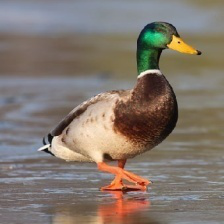

In [9]:
def showFirstBird(bird_name="MALLARD DUCK"):
    """
    Print out file paths of images in the valid_dir and show the first image of a given species.
    """
    import glob
    img_files = []
    for img in glob.glob(os.path.join(valid_dir, bird_name)+"/*"):
        img_files.append(img)
        
    for i in img_files:
        print(i) # Print file path
        ifile = tf.io.read_file(i) # Reads the contents of file
        img_dec = tf.io.decode_image(ifile) # Decodes an image file
        print("File shape: ", img_dec.shape, "\n")
        
    img = PIL.Image.open(str(img_files[0]))
    return img
    
showFirstBird()

# 2. Create a dataset for the model
## Generate tf.data.Dataset objects from a directory
Take image files from a directory on disk and generate a ``tf.data.Dataset`` for train, validation and test dataset. ``image_dataset_from_directory()`` is a special TensorFlow data generator function.

In [10]:
"""
Achieving peak performance requires an efficient input pipeline that delivers data for 
the next step before the current step has finished. The tf.data API helps to build flexible 
and efficient input pipelines.
~ https://www.tensorflow.org/guide/data_performance
"""
IMAGE_SIZE=(150,150) # original size: 224,224 # Resolution decreased to speed up training time
BATCH_SIZE=32 # default=32
SEED=42
np.random.seed(42)
tf.random.set_seed(42)

train_data = image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.8,
    label_mode='categorical',
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE,
    subset='training',
    seed=SEED,
    shuffle=True   # default
)
class_names = train_data.class_names
num_classes = len(class_names)
#print("Class names: ", class_names[:5])

valid_data = image_dataset_from_directory(
    directory=valid_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    shuffle=True   # default
)

test_data = image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    shuffle=False
)

Found 58388 files belonging to 400 classes.
Using 11678 files for training.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


## Configure the dataset for performance
To prevent I/O blocking while retrieving data from disk we use buffered prefetching.  

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used 
to decouple the time when data is produced from the time when data is consumed. In particular, 
the transformation uses a background thread and an internal buffer to prefetch elements from 
the input dataset ahead of the time they are requested. The number of elements to prefetch 
should be equal to (or possibly greater than) the number of batches consumed by a single training step. 
You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the 
tf.data runtime to tune the value dynamically at runtime.

 ~ https://www.tensorflow.org/guide/data_performance

In [11]:
train_data_pf = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)
valid_data_pf = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)
test_data_pf = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# 3. Create Model 

## Define model architecture
**Take aways from [Gabriel Atkin's Age Prediction From Facial Images](https://www.youtube.com/watch?v=9AnCNBL8c6Q&t=661s):**
- Recurrent feature extraction
- Flatten layer
    - layers.Flatten()(x) # sometimes too many features
    - layers.GlobalAveragePooling2D()(x) # average across the first 2 dimensions
- 

 """    # convolution layer
    layers.Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(),
    
    # convolution layer
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # convolution layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # convolution layer
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),"""

In [12]:
INPUT_SHAPE=(150, 150, 3)

model = tf.keras.models.Sequential([
    
    # handy input layer
    layers.Input(INPUT_SHAPE),
    
    # convolution layers
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),  
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.BatchNormalization(),


    
    # Last fully-connected layer
    layers.Flatten(input_shape=INPUT_SHAPE),
    layers.Dense(units=num_classes, activation='softmax')
])
keras.backend.clear_session()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 70, 64)        2

## Compile model
- Cross-entropy is the default loss function to use for multi-class classification problems. ~ [Link](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/#:~:text=Cross%2Dentropy%20is%20the%20default%20loss%20function%20to%20use%20for%20multi%2Dclass%20classification%20problems.)
    - IMPORTANT: The function requires that the output layer is configured with an n nodes (one for each class), in this case three nodes, and a ‘softmax‘ activation in order to predict the probability for each class.

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # standard for multi-class clf    
    metrics=['accuracy']
)

### Plot the model architecture

In [14]:
dot_img_file = '/tmp/'+model.name+'.png'
model_img = tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
#model_img

## Train model

In [15]:
EPOCHS = 5
STEPS = int(len(train_data_pf)*0.01)
VALIDATION_STEPS = int(len(valid_data_pf)*0.1)

print("|Epochs:", EPOCHS, "| Steps:", STEPS, "| Validation steps:", VALIDATION_STEPS, 
      "|\n**********************************************")


history = model.fit(
    train_data_pf,
    validation_data=valid_data_pf,
    validation_steps=10, # at the end of each epoch
    epochs=EPOCHS,
    workers=-1,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping( 
            #Prevent overfitting through early stopping
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1
)])

model.save("birds.h5")

|Epochs: 5 | Steps: 1 | Validation steps: 3 |
**********************************************
Epoch 1/5


2022-05-30 22:14:40.090711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-30 22:14:42.794043: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


183/183 [==============================] - 49s 212ms/step - loss: 8.0603 - accuracy: 0.0174 - val_loss: 7.0693 - val_accuracy: 0.0156
Epoch 2/5
183/183 [==============================] - 21s 110ms/step - loss: 2.2891 - accuracy: 0.5569 - val_loss: 8.0321 - val_accuracy: 0.0500
Epoch 3/5
183/183 [==============================] - 21s 110ms/step - loss: 0.3715 - accuracy: 0.9058 - val_loss: 7.6584 - val_accuracy: 0.0703
Epoch 4/5
183/183 [==============================] - 21s 111ms/step - loss: 0.1311 - accuracy: 0.9673 - val_loss: 8.1958 - val_accuracy: 0.0656
Epoch 5/5
183/183 [==============================] - 20s 109ms/step - loss: 0.0694 - accuracy: 0.9826 - val_loss: 8.1147 - val_accuracy: 0.0703


In [16]:
# Evaluation
scores = model.evaluate(test_data_pf, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

32/32 [==============================] - 6s 191ms/step - loss: 8.3636 - accuracy: 0.0580
Accuracy: 5.80%


### Questions:
- **What is ``tf.keras.layers.Conv2D`` ?**
    - Specifies a convolution layer.
    - Let's look at an **example** ([Details](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D#args_1)): <br>
layers.Conv2D(  
...filters=16,   # dimensionality of the output space  
...kernel_size=3,   # int or tuple, height and width of the 2D convolution window  
...strides=(1,1),   # DEFAULT  
...padding='same',   # 'valid' -> no padding, 'same' -> same as input  
...groups=1,   # DEFAULT; applies filter to smaller parts of the image (~ Lupe)  
...activation='relu'   # there are many more [here](https://www.tensorflow.org/api_docs/python/tf/keras/activations)  
) 


- **What is ``tf.keras.layers.MaxPooling2D`` ?**
    - Downsamples the input along its spatial dimensions by taking the maximum value over an input window (size=``pool_size``) for each channel of the input
    - ``strides`` will shift the window
    - ``padding`` changes output size only if 'valid'  
    
    
- **What is ``tf.keras.layers.Flatten`` ?**
    - Flattens the input. Does not affect the batch size.
    - layers.Flatten()(x) # sometimes too many features
    - layers.GlobalAveragePooling2D()(x) # average across the first 2 dimensions
    
    
- **What is ``tf.keras.layers.Dropout`` ?**
    - randomly sets input units to 0 with a frequency of ``rate`` at each step during training
    - helps to prevent overfitting
    
    
- **What is ``tf.keras.layers.Dense`` ?**
    - ``units`` is a positive integer, dimensionality of the output space.
    - specify activation function to use with ``activation`` (DEFAULT='linear')
    

Source: http://bit.ly/2lXXdw5 (the Rock-Paper-Scissor model from YT)

### Model architecture from TensorFlow tutorial ([Link](https://www.tensorflow.org/tutorials/images/classification#:~:text=layers.Resizing%20layer.-,Create%20the%20model,-The%20Sequential%20model))
The Sequential model consists of three convolution blocks (``tf.keras.layers.Conv2D``) with a max pooling layer (``tf.keras.layers.MaxPooling2D``) in each of them. <br>
There's a fully-connected layer (``tf.keras.layers.Dense``) with 128 units on top of it that is activated by a ReLU activation function ('**relu**'). <br>
This model has not been tuned for high accuracy.

In [17]:
# build after Gabriel Atkin YT video

"""# Input layer
inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Normalization
#x = layers.Rescaling(1./IMAGE_SIZE[0])(inputs) # -> 2.5% DONT NORMALIZE

# Convolutional layer
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs) # convolution
x = layers.MaxPool2D()(x) # downsampling
#x = layers.MaxPool2D(pool_size=2)(x) # downsampling

# Convolutional layer
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x) # convolution
x = layers.MaxPool2D()(x) # downsampling
#x = layers.MaxPool2D(pool_size=2)(x) # downsampling

# Convolutional layer
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) # convolution
x = layers.MaxPool2D()(x) # downsampling
#x = layers.MaxPool2D(pool_size=2)(x) # downsampling

# Convolutional layer
x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) # convolution
x = layers.MaxPool2D()(x) # downsampling
#x = layers.MaxPool2D(pool_size=2)(x) # downsampling

# Flattening layer
x = layers.GlobalAveragePooling2D()(x) 
#x = layers.GlobalMaxpooling2D()(x) 
# x = layery.flatten()(x)

# Dense layer
x = layers.Dense(units=256, activation='relu')(x) # twice as many units as features after flattening
x = layers.Dense(units=256, activation='relu')(x)

# Output layer
outputs = layers.Dense(units=num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)"""

"# Input layer\ninputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))\n\n# Normalization\n#x = layers.Rescaling(1./IMAGE_SIZE[0])(inputs) # -> 2.5% DONT NORMALIZE\n\n# Convolutional layer\nx = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs) # convolution\nx = layers.MaxPool2D()(x) # downsampling\n#x = layers.MaxPool2D(pool_size=2)(x) # downsampling\n\n# Convolutional layer\nx = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x) # convolution\nx = layers.MaxPool2D()(x) # downsampling\n#x = layers.MaxPool2D(pool_size=2)(x) # downsampling\n\n# Convolutional layer\nx = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) # convolution\nx = layers.MaxPool2D()(x) # downsampling\n#x = layers.MaxPool2D(pool_size=2)(x) # downsampling\n\n# Convolutional layer\nx = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) # convolution\nx = layers.MaxPool2D()(x) # downsampling\n#x = layers.MaxPool2D(pool_size=2)(x) # downs

In [18]:
# My model adapted from web

"""INPUT_SHAPE=(150, 150, 3)

# 16, 32, 64, 128, 512 -> BUT number should decrease towards the number of classes (400)
neurons = [16, 32, 64, 128]

model = tf.keras.models.Sequential([
    # Rescaling layer to standardize data (Preprocessing)
    #layers.Rescaling(scale=1./INPUT_SHAPE[0], input_shape=INPUT_SHAPE),
    
    # The first convolution layer
    layers.Conv2D(
        input_shape=INPUT_SHAPE,
        filters=neurons[0], # 16, 32, 64
        kernel_size=(3,3), 
        padding='same', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(
        pool_size=(2,2), # DEFAULT
        strides=None, # DEFAULT
        padding='same', # DEFAULT
    ),
    
    # The second convolution layer
    layers.Conv2D(
        filters=neurons[1], # 16, 32, 64
        kernel_size=(3,3), 
        padding='same', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(),
    
    # The third convolution layer
    layers.Conv2D(
        filters=neurons[2], # 16, 32, 64
        kernel_size=(3,3), 
        padding='same', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(),
    
    # Process data for dense layers
    layers.Flatten(),
    #layers.Dropout(0.2), # higher -> more regularization 
    layers.BatchNormalization(),


    # First fully-connected layer
    layers.Dense(
        units=neurons[3], # 128
        activation='relu'
    ),
    
    # Last fully-connected layer
    layers.Dense(
        units=num_classes,
        activation='softmax',
    )
])""";

In [19]:
# Basically model from web

"""INPUT_SHAPE=(224, 224,3) 

model = tf.keras.models.Sequential([
    # Rescaling layer to standardize data (Preprocessing)
    #layers.Rescaling(scale=1./INPUT_SHAPE[0], input_shape=INPUT_SHAPE),
    
    # The first convolution layer
    layers.Conv2D(
        input_shape=INPUT_SHAPE,
        filters=16, # 16, 32, 64
        kernel_size=(3,3), 
        padding='valid', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(
        pool_size=(2,2), # DEFAULT
        strides=None, # DEFAULT
        padding='valid', # DEFAULT
    ),
    
    # The second convolution layer
    layers.Conv2D(
        filters=32, # 16, 32, 64
        kernel_size=(3,3), 
        padding='valid', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(),
    
    # The third convolution layer
    layers.Conv2D(
        filters=64, # 16, 32, 64
        kernel_size=(3,3), 
        padding='valid', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(),
    
    # Process data for dense layers
    layers.Flatten(),
    #tf.keras.layers.Dropout(0.2), # higher -> more regularization 

    # First fully-connected layer
    layers.Dense(
        units=128, 
        activation='relu'
    ),
    
    # Last fully-connected layer
    layers.Dense(
        units=num_classes,
        activation=None,
    )
])""";

**Optimizers:**
- Adam: a sensible default optimizer
- Nadam (Nesterov-accelerated Adam)
- RMSProp (oftentimes used for regression) -> keras default

In [20]:
"""model.compile(
    optimizer='adam', # DEFAULT 'rmsprop'
    loss='mean_absolute_error', 
    metrics=['accuracy']
)"""

# I used this last time
"""model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)"""

"model.compile(\n    loss=keras.losses.categorical_crossentropy,\n    optimizer='adam',\n    metrics=['accuracy']\n)"

In [21]:
#model.summary()

### Links:
- TF model.fit() -> https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- ...

# 4. Train model

In [22]:
"""EPOCHS = 5
STEPS = int(len(train_data_pf)*0.01)
VALIDATION_STEPS = int(len(valid_data_pf)*0.1)
print("|Epochs:", EPOCHS, "| Steps:", STEPS, "| Validation steps:", VALIDATION_STEPS, 
      "|\n**********************************************")

history = model.fit(   .
    train_data_pf, 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS, 
    validation_data=valid_data_pf, 
    validation_steps=VALIDATION_STEPS, #3
    verbose=1
)

model.save("birds.h5")"""

'EPOCHS = 5\nSTEPS = int(len(train_data_pf)*0.01)\nVALIDATION_STEPS = int(len(valid_data_pf)*0.1)\nprint("|Epochs:", EPOCHS, "| Steps:", STEPS, "| Validation steps:", VALIDATION_STEPS, \n      "|\n**********************************************")\n\nhistory = model.fit(   .\n    train_data_pf, \n    epochs=EPOCHS, \n    steps_per_epoch=STEPS, \n    validation_data=valid_data_pf, \n    validation_steps=VALIDATION_STEPS, #3\n    verbose=1\n)\n\nmodel.save("birds.h5")'

## Training Results
### Visualize Training

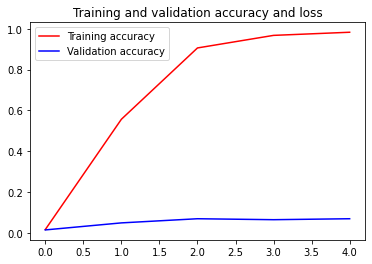

<Figure size 432x288 with 0 Axes>

In [23]:
def plotHistory(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    #plt.plot(epochs, loss, 'g', label='Training loss')
    #plt.plot(epochs, val_loss, 'o', label='Validation loss')
    
    plt.title('Training and validation accuracy and loss')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

plotHistory(history)

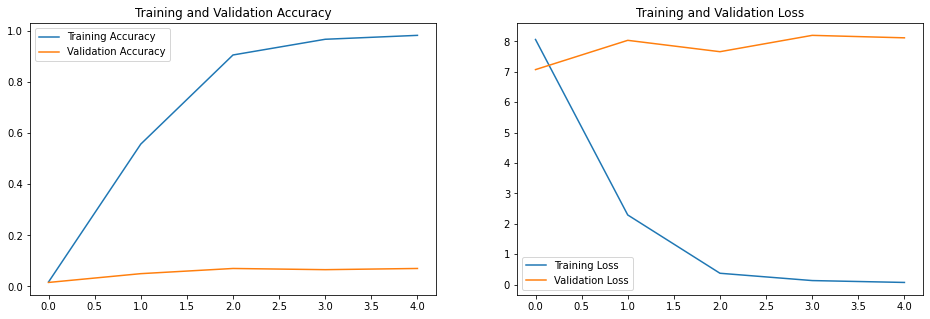

In [24]:
def plotHistory2(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()#loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()#loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
plotHistory2(history)

# 5. Evaluation

In [25]:
scores = model.evaluate(test_data_pf, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

32/32 [==============================] - 2s 65ms/step - loss: 8.3636 - accuracy: 0.0580
Accuracy: 5.80%


---
# README
after the first meeting

### Aufteilung
- keras tensorflow - Clemens
- pytorch - Jakob
- PCA + preprocessing - Lena 


### Methoden 
- pca?
- image segementation
- Wie laden wir die Bilder von der CSV ins Notebook?
- Wieviele Datenreihen brauchen wir? 
data set
| train    58388 | test      2000 | valid     2000 |


# Links
## Good Notebook for reference
### https://www.kaggle.com/code/ashwinshetgaonkar/bird-classifier-tensorflow-beginner

## Learn TensorFlow in this notebook
### http://bit.ly/2lXXdw5